### Introduction

- Name: Amelia Dobronyi
- Instructor: Abhineet Kulkari
- Pace: Flex

### Project Plan

The purpose of this project is to create a recommendation system that produces movie recommendations for watchers based on their previous ratings. To clarify further, a movie water 'user' will input a set of ratings on movies that they have seen, and using these ratings as well as ratings inputted by other users, we can create implied ratings for the movies the user has not seen, and then take those top ratings to produce recommendations for the user. There are two typical approaches to creating such ratings:

*Collaborative filtering*: A system to produce ratings based solely on ratings and using no other endogenous data about either the users or the films. This system makes use of similarity algorithms (more on those below) that either compare users to other users or compare movies to other movies.

*Content hybrid*: A system to create recommendations based on endogenous features about the product being recommended. In this context, a hybrid rating system would use endogenous data about the movies (i.e. genre, cast, runtime) to find similar movies to recommend to a user.

The surprise package in python allows for the easy implementation of a collaborative filtering recommendation system.

Given the capabilities in the surprise package for creating a recommendation system, the code is split into the following portions:

1. Import data and transform into usable form compatible with surprise package
2. Use GridSearchCV on the training data to fit various models using collaborative filtering
3. Introduce content filtering to see if it improves results
4. Create the recommender method

### Data Preparation

Before building any models, I will import the data, check it for any duplicates and missing values, and then proceed to make sure it is in a form that can be fed into the surprise package's functions.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# surprise
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split,GridSearchCV,cross_validate
from surprise.prediction_algorithms import knns,SVD,SVDpp,NMF,SlopeOne,CoClustering
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [2]:
# import data
df_movies = pd.read_csv('./data/movies.csv')
df_ratings = pd.read_csv('./data/ratings.csv')

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# check for missing values
print(df_movies.isna().sum())

movieId    0
title      0
genres     0
dtype: int64


In [5]:
# check for duplicate movies
print(df_movies.duplicated().sum())

0


In [6]:
# get number of movies
df_movies.shape[0]

9742

In [7]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
# drop timestamp column
df_ratings = df_ratings.drop('timestamp',axis=1)
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
# create a dataframe of just average ratings for movies - note note all movies have ratings
df_meanRatings = df_ratings.groupby('movieId').mean().drop(columns='userId')

In [10]:
df_meanRatings

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
...,...
193581,4.000000
193583,3.500000
193585,3.500000


In [11]:
# check for missing values
df_ratings.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [12]:
# check for duplicates
df_ratings.duplicated().sum()

0

In [13]:
# get number of users
len(list(set(df_ratings['userId'])))

610

In [14]:
df_movies.shape

(9742, 3)

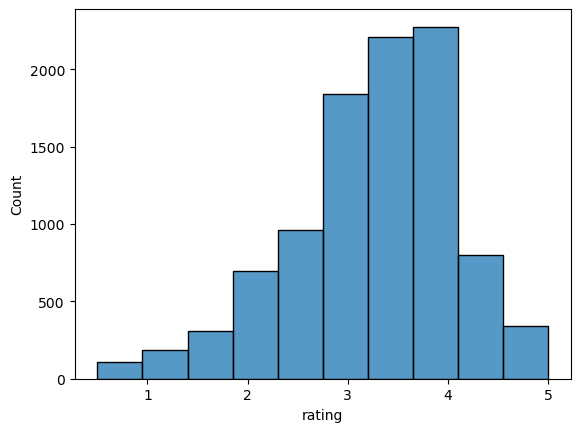

In [15]:
# plot movie ratings
sns.histplot(df_ratings.groupby('movieId').mean()['rating'],bins=10);

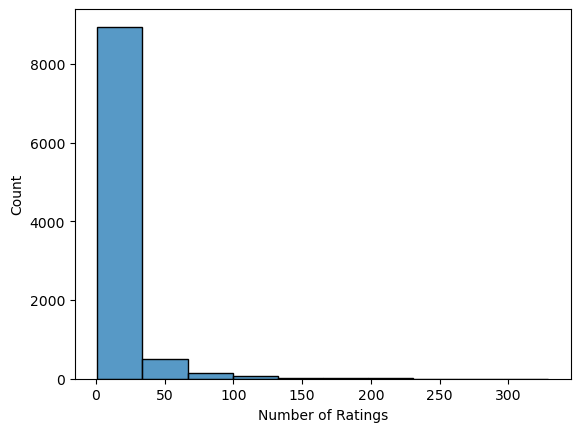

In [16]:
# plot number of ratings
sns.histplot(df_ratings.groupby('movieId').count()['rating'],bins=10);
plt.xlabel('Number of Ratings');

Now that we have examined the data and gotten a sense of its dimensionality, we can convert it into a usable form for the surprise package functions.

In [17]:
# create a reader instance and read in the data
reader = Reader()
data = Dataset.load_from_df(df_ratings,reader)

As expected from above, there are 610 users in the dataset, all of which are included in the training set. It is important to note that there is a much larger number of movies than number of users, which is expected - a single user can rate many movies. From the perspective of making recommendations, it will be much faster for the optimizer to use similarities between users than movies, so for the first part of the project, that is what the focus will be.

Rather than using a test-train split, which would withhold some of the data for final validation of the model, I have opted to rather use all of the data for cross-validation, and then produce an in-sample error statistic using the final model selected.

Given that we are going to focus on similarities between users to start, there are several ways we can approach this. The surprise package offers four kinds of similarity algorithms that we can use from:

1. cosine similarity
2. mean-square difference similarity
3. pearson similarity

Additionally, there are numerous approaches to the actual prediction algorithm. The most basic are SVD and KNN, though we will examine the broad set of algortithms in this notebook.

Additionally, we need to consider the choice of error metric. The surprise function offers multiple options, but the two most commonly chosen are MAE (mean absolute error) and RMSE (root mean squared error). Both are useful in that the error is interpretable as a function of the result unit, i.e. an RMSE or MAE of 1 would both represent the average error in the rating being off by a value of 1 (out of 10). The difference is that MAE treats each deviation the same, whereas RMSE penalizes larger deviations from the true value. The choice of error in model selection thus relies on our own interpretation of model value - is the bigger risk the recommendation of a movie very far off from the user's preferences, or movies that are perhaps just so-so but maybe more frequent? We can look at both in the code below, but most likely the RMSE will be used to deliver the final model. 

The documentation for surprise selection algorithms can be found on its website:
https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html

### Model Selection

The first model that we will try fitting is a basic KNN (k-nearest neighbors model). Given a number of clusters, the algorithm attempts to find the most similar observations and use those to create a previously unknown rating.

In [18]:
# create a new dictionary to store results - will allow storage of best model params and scores for each
dict_results = {}
np.random.seed(100)

In [19]:
gs_params_knnBasic = {'k':[10,25,40,55,70],
                      'min_k':[1,5,10],
                      'sim_options': {
                          'name': ['msd','cosine','pearson'],
                          'user_based': [True]},
                      'bsl_options': {
                          'name': ['als','sgd']}}

gs_knnBasic = GridSearchCV(knns.KNNBasic,param_grid=gs_params_knnBasic,n_jobs=-1,joblib_verbose=0)
gs_knnBasic.fit(data)

In [20]:
gs_knnBasic.best_score

{'rmse': 0.9405066327227267, 'mae': 0.7174767309989745}

In [21]:
gs_knnBasic.best_params

{'rmse': {'k': 10,
  'min_k': 5,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 10,
  'min_k': 1,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [22]:
# using past CV results, run another iteration
gs_params_knnBasic_2 = {'k':[5,10,15,20],
                        'min_k':[2,5,8],
                        'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                        'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnBasic_2 = GridSearchCV(knns.KNNBasic,param_grid=gs_params_knnBasic_2,n_jobs=-1,joblib_verbose=0)
gs_knnBasic_2.fit(data)

In [23]:
gs_knnBasic_2.best_score    

{'rmse': 0.9312683813898914, 'mae': 0.7110237717907308}

In [24]:
gs_knnBasic_2.best_params

{'rmse': {'k': 15,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 10,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [25]:
# using past CV results, run another iteration
gs_params_knnBasic_3 = {'k':[10,15,20],
                        'min_k':[1,2,3,5],
                        'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                        'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnBasic_3 = GridSearchCV(knns.KNNBasic,param_grid=gs_params_knnBasic_3,n_jobs=-1,joblib_verbose=0)
gs_knnBasic_3.fit(data)

In [26]:
gs_knnBasic_3.best_score

{'rmse': 0.9323747420652919, 'mae': 0.713042820271753}

In [27]:
gs_knnBasic_3.best_params

{'rmse': {'k': 15,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 15,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [28]:
# add results to dict
dict_results['knnBasic'] = {'score': gs_knnBasic_3.best_score,
                            'params':gs_knnBasic_3.best_params}

Now we can try an improvement over basic KNN algorithm by implementing KNN with baseline, which incorporates the baseline rating, or some best guess of what the rating should be. This method has the advantage of having the same parameters as the basic KNN algo.

In [29]:
gs_params_knnBaseline = {'k':[10,25,40,55,70],
                         'min_k':[1,5,10],
                         'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                         'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnBaseline = GridSearchCV(knns.KNNBaseline,param_grid=gs_params_knnBaseline,n_jobs=-1,joblib_verbose=0)
gs_knnBaseline.fit(data)

In [30]:
gs_knnBaseline.best_score

{'rmse': 0.8650105606338689, 'mae': 0.662947895827479}

In [31]:
gs_knnBaseline.best_params

{'rmse': {'k': 55,
  'min_k': 10,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 25,
  'min_k': 5,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [32]:
gs_params_knnBaseline_2 = {'k':[20,30,40,50,60],
                           'min_k':[2,5,10,15],
                           'sim_options': {
                               'name': ['msd','cosine','pearson'],
                               'user_based': [True]},
                           'bsl_options': {
                               'name': ['als','sgd']}}

gs_knnBaseline_2 = GridSearchCV(knns.KNNBaseline,param_grid=gs_params_knnBaseline_2,n_jobs=-1,joblib_verbose=0)
gs_knnBaseline_2.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearso

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine s

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine simila

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine si

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson

In [33]:
gs_knnBaseline_2.best_score

{'rmse': 0.8649792201933604, 'mae': 0.6627454709438652}

In [34]:
gs_knnBaseline_2.best_params

{'rmse': {'k': 40,
  'min_k': 15,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 10,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [35]:
# add results to dict
dict_results['knnBaseline'] = {'score': gs_knnBaseline_2.best_score,
                               'params': gs_knnBaseline_2.best_params}

KNN with means is yet another iteration of the KNN algorithm, except rather than a baseline estimate, it uses the mean rating of each user as a comparison point the neighboring observations.

In [36]:
gs_params_knnMeans = {'k':[10,25,40,55,70],
                      'min_k':[1,5,10],
                      'sim_options': {
                          'name': ['msd','cosine','pearson'],
                          'user_based': [True]},
                      'bsl_options': {
                          'name': ['als','sgd']}}

gs_knnMeans = GridSearchCV(knns.KNNWithMeans,param_grid=gs_params_knnMeans,n_jobs=-1,joblib_verbose=0)
gs_knnMeans.fit(data)

In [37]:
gs_knnMeans.best_score

{'rmse': 0.8919153315315806, 'mae': 0.6797811079059113}

In [38]:
gs_knnMeans.best_params

{'rmse': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [39]:
gs_params_knnMeans_2 = {'k':[30,40,50],
                        'min_k':[2,5,8],
                        'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                        'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnMeans_2 = GridSearchCV(knns.KNNWithMeans,param_grid=gs_params_knnMeans_2,n_jobs=-1,joblib_verbose=0)
gs_knnMeans_2.fit(data)

In [40]:
gs_knnMeans_2.best_score

{'rmse': 0.8905653044675317, 'mae': 0.6791493965145559}

In [41]:
gs_knnMeans_2.best_params

{'rmse': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [42]:
# add results to dict
dict_results['knnMeans'] = {'score': gs_knnMeans_2.best_score,
                            'params': gs_knnMeans_2.best_params}

We now switch to using an SVD algorithm to compute estimated ratings. SVD is a matrix decomposition method that allows the data matrix to be decomposed into three separate matrices referring to users, movies, and cross-weights. Though the cross-weights lack interpretability on their own, this single matrix is composed of the features that that transform user and movie data into estimated ratings.

In [43]:
gs_params_svd = {'n_factors':[20,50,100],
                 'biased':[True,False],
                 'reg_all':[0.01,0.02,0.05],
                 'lr_all':[0.005,0.0075,0.01]}

gs_svd = GridSearchCV(SVD,param_grid=gs_params_svd,n_jobs=-1,joblib_verbose=0)
gs_svd.fit(data)

In [44]:
gs_svd.best_score

{'rmse': 0.8598473463959669, 'mae': 0.6589184034968089}

In [45]:
gs_svd.best_params

{'rmse': {'n_factors': 100, 'biased': True, 'reg_all': 0.05, 'lr_all': 0.01},
 'mae': {'n_factors': 100, 'biased': True, 'reg_all': 0.05, 'lr_all': 0.01}}

In [46]:
gs_params_svd_2 = {'n_factors':[50,100,150],
                   'biased':[True,False],
                   'reg_all':[0.03,0.05,0.08],
                   'lr_all':[0.0075,0.01,0.0125]}

gs_svd_2 = GridSearchCV(SVD,param_grid=gs_params_svd_2,n_jobs=-1,joblib_verbose=0)
gs_svd_2.fit(data)

In [47]:
gs_svd_2.best_score

{'rmse': 0.8550193437800313, 'mae': 0.656682309443578}

In [48]:
gs_svd_2.best_params

{'rmse': {'n_factors': 150, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.0125},
 'mae': {'n_factors': 150, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.0125}}

In [49]:
gs_params_svd_3 = {'n_factors':[125,150,175],
                   'biased':[True,False],
                   'reg_all':[0.06,0.08,0.10],
                   'lr_all':[0.01,0.0125,0.02]}

gs_svd_3 = GridSearchCV(SVD,param_grid=gs_params_svd_3,n_jobs=-1,joblib_verbose=0)
gs_svd_3.fit(data)

In [50]:
gs_svd_3.best_score

{'rmse': 0.8517204083103966, 'mae': 0.6531208924096522}

In [51]:
gs_svd_3.best_params

{'rmse': {'n_factors': 150, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.02},
 'mae': {'n_factors': 150, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.02}}

In [52]:
gs_params_svd_4 = {'n_factors':[160,175,190,200],
                   'biased':[True,False],
                   'reg_all':[0.06,0.08,0.10],
                   'lr_all':[0.015,0.02,0.025]}

gs_svd_4 = GridSearchCV(SVD,param_grid=gs_params_svd_4,n_jobs=-1,joblib_verbose=0)
gs_svd_4.fit(data)

In [53]:
gs_svd_4.best_score

{'rmse': 0.8505072097656026, 'mae': 0.6523390857496686}

In [54]:
gs_svd_4.best_params

{'rmse': {'n_factors': 175, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.025},
 'mae': {'n_factors': 175, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.025}}

In [55]:
# add results to dict
dict_results['SVD'] = {'score': gs_svd_4.best_score,
                       'params': gs_svd_4.best_params}

SVD++ is an extension of the Funk SVD algorithm, which considers implicit ratings. An implicit rating takes into consideration a user's choice to rank a specific movie, not just the rating itself.

In [56]:
svdpp = SVDpp(n_factors=50)
cv_svdpp = cross_validate(svdpp, data, n_jobs=-1)

In [57]:
np.mean(cv_svdpp['test_rmse'])

0.8636984026287949

Non-negative matrix factorization (NMF) is similar to SVD, except it uses two matrix factorization instead of three, and thus does not utilize the sigma matrix (the one with the features) that can be inspected on its own.

In [58]:
gs_params_nmf = {'n_factors':[10,25,50],
                 'biased':[True,False]}

gs_nmf = GridSearchCV(NMF,param_grid=gs_params_nmf,n_jobs=-1,joblib_verbose=0)
gs_nmf.fit(data)

In [59]:
gs_nmf.best_score

{'rmse': 0.8750526231754995, 'mae': 0.6712035393120925}

In [60]:
gs_nmf.best_params

{'rmse': {'n_factors': 10, 'biased': True},
 'mae': {'n_factors': 10, 'biased': True}}

In [61]:
gs_params_nmf_2 = {'n_factors':[1,5,10,15],
                   'biased':[True,False]}

gs_nmf_2 = GridSearchCV(NMF,param_grid=gs_params_nmf_2,n_jobs=-1,joblib_verbose=0)
gs_nmf_2.fit(data)

In [62]:
gs_nmf_2.best_score

{'rmse': 0.8694843035204445, 'mae': 0.6657296980899611}

In [63]:
gs_nmf_2.best_params

{'rmse': {'n_factors': 1, 'biased': True},
 'mae': {'n_factors': 1, 'biased': True}}

In [64]:
# add results to dict
dict_results['NMF'] = {'score': gs_nmf_2.best_score,
                       'params': gs_nmf_2.best_params}

Finally, co-clustering is an approach similar to KNN in which users and movies are assigned to clusters or co-clusters, and a given estimate is calculated as a function of the means of the three clusters.

In [65]:
cc = CoClustering()
cv_cc = cross_validate(cc, data, n_jobs=-1)

In [66]:
np.mean(cv_cc['test_rmse'])

0.9426557247306301

In [67]:
gs_params_cc = {'n_cltr_u':[1,3,5,8],
                'n_cltr_i':[1,3,5,8]}

gs_cc = GridSearchCV(CoClustering,param_grid=gs_params_cc,n_jobs=-1,joblib_verbose=0)
gs_cc.fit(data)

In [68]:
gs_cc.best_score

{'rmse': 0.9325669363923061, 'mae': 0.7218028511055599}

In [69]:
gs_cc.best_params

{'rmse': {'n_cltr_u': 1, 'n_cltr_i': 1}, 'mae': {'n_cltr_u': 1, 'n_cltr_i': 1}}

In [70]:
gs_params_cc_2 = {'n_cltr_u':[1,2,3],
                  'n_cltr_i':[1,2,3],
                  'n_epochs':[5,10,20,50]}

gs_cc_2 = GridSearchCV(CoClustering,param_grid=gs_params_cc_2,n_jobs=-1,joblib_verbose=0)
gs_cc_2.fit(data)

In [71]:
gs_cc_2.best_score

{'rmse': 0.9327354854622445, 'mae': 0.7223049521949702}

In [72]:
gs_cc_2.best_params

{'rmse': {'n_cltr_u': 1, 'n_cltr_i': 1, 'n_epochs': 5},
 'mae': {'n_cltr_u': 3, 'n_cltr_i': 1, 'n_epochs': 20}}

In [73]:
# add results to dict
dict_results['CC'] = {'score': gs_cc_2.best_score,
                       'params': gs_cc_2.best_params}

In [74]:
dict_results

{'knnBasic': {'score': {'rmse': 0.9323747420652919, 'mae': 0.713042820271753},
  'params': {'rmse': {'k': 15,
    'min_k': 2,
    'sim_options': {'name': 'msd', 'user_based': True},
    'bsl_options': {'name': 'als'}},
   'mae': {'k': 15,
    'min_k': 2,
    'sim_options': {'name': 'msd', 'user_based': True},
    'bsl_options': {'name': 'als'}}}},
 'knnBaseline': {'score': {'rmse': 0.8649792201933604,
   'mae': 0.6627454709438652},
  'params': {'rmse': {'k': 40,
    'min_k': 15,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}},
   'mae': {'k': 40,
    'min_k': 10,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}}}},
 'knnMeans': {'score': {'rmse': 0.8905653044675317, 'mae': 0.6791493965145559},
  'params': {'rmse': {'k': 40,
    'min_k': 5,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}},
   'mae': {'k': 40,
    'min_k': 5,
    'sim_options': {'na

From the above cross-validation, we have our model which produced the best results on either metrics. We can now implement this model on the full dataset and see what movie recommendations it makes for a randomly selected user.

In [75]:
data_full = data.build_full_trainset()

model = SVD(n_factors=190,biased=True,reg_all=0.08,lr_all=0.02)
model.fit(data_full)

In [76]:
# extract the raw ratings from the original data to get predictions
testset = data.construct_testset(raw_testset=data.raw_ratings)
len(testset)

100836

In [77]:
predictions = model.test(testset)

In [78]:
# calculate rmse for model over full set
rmse = accuracy.rmse(predictions, verbose=True)

RMSE: 0.5499


In [79]:
mae = accuracy.mae(predictions, verbose=True)

MAE:  0.4233


In [80]:
# extract observed and predicted ratings from the predictions
r_ui = [pred[2] for pred in predictions]
r_hat = [pred[3] for pred in predictions]

In [81]:
# verify RMSE calculation from raw data
np.sqrt(np.sum((np.array(r_ui)-np.array(r_hat))**2)/len(predictions))

0.5498861904965617

In [82]:
np.sum(abs((np.array(r_ui)-np.array(r_hat))))/len(predictions)

0.42332603940244673

We see that using our model on the full amount of data, we have a much lower RMSE of 0.55. While this metric is valid on its own, we cannot compare it to those generated during the CV process because the matrices that are used contribute to the overall performance of the model, and in the cross-validation process, we are effectively creating a matrix for each fold that we test, hence the two datasets are not comparable, even if the cross-validations subsets are taken from the same dataset.

Now that we have a baseline model that we can use on the given data, we will introduce some content-based filtering as well to see if we can lower the in-sample RMSE further.

## Content-based Filtering

Since the surprise package is not able to handle features other than user ratings, any content-based filtering needs to happen indepdenently. There are many approaches we could take, but for this recommender system, we will implement a very basic one using just one other factor - movie genres. In doing so, we will consider each user's genre preference, as indicated by how they rate movies of a single genre relative to the rest, and try to improve upon the model-generated ratings from above.

In [83]:
# create a matrix of genres by movie
df_genres = pd.get_dummies(df_movies['genres'].str.split('|').apply(pd.Series).stack()).groupby(level=0).sum()
df_genres['movieId'] = df_movies['movieId']
df_genres = df_genres.set_index('movieId')

In [84]:
df_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193583,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
193585,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [85]:
# append genre matrix to ratings matrix to see genre corresponding to each rating
df_ratings_genres = df_ratings.set_index('movieId').join(df_genres)
df_ratings_genres

,userId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15,2.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,184,4.0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
193583,184,3.5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
193585,184,3.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
# create matrix to get mean ratings of genre by each user
df_user_genres = df_ratings_genres.groupby('userId').mean()
df_user_genres.iloc[:,1:] = 0

/var/folders/33/b9z3l98x2r3fz5kyh065tz7c0000gn/T/ipykernel_71192/1423161622.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_user_genres.iloc[:,1:] = 0


In [87]:
df_user_genres

,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.948276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.435897,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3.555556,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3.636364,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.657399,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
607,3.786096,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
608,3.134176,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
# populate the above matrix with each genres rating differential to average user rating
# do this by extracting matrix for each user and performing calc on sub-matrix
for user in list(df_user_genres.index):
    df_user = df_ratings_genres[df_ratings_genres['userId'] == user]
    for c in list(df_genres.columns):
        if(df_user[c].sum() > 0):
            df_user_genres.loc[user,c] = df_user['rating'].dot(df_user[c])/df_user[c].sum() - df_user['rating'].mean()
        else:
            df_user_genres.loc[user,c] = 0

In [89]:
df_user_genres

,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,0.0,-0.044157,0.021856,0.323276,0.181240,-0.089271,-0.010824,0.000000,0.163032,...,0.633621,-0.895791,0.000000,0.315439,-0.199713,-0.058687,-0.141379,-0.220925,0.133621,-0.080665
2,3.948276,0.0,0.006270,0.218391,0.000000,0.000000,0.051724,-0.148276,0.385057,-0.065923,...,0.000000,-0.948276,-0.198276,0.000000,0.051724,0.551724,-0.073276,-0.248276,0.551724,-0.448276
3,2.435897,0.0,1.135531,0.291375,-1.935897,-1.935897,-1.435897,-1.935897,0.000000,-1.685897,...,0.000000,2.251603,0.000000,-1.935897,2.564103,-1.935897,1.764103,1.706960,-1.935897,0.000000
4,3.555556,0.0,-0.235556,0.099617,0.444444,0.244444,-0.045940,0.259259,0.444444,-0.072222,...,0.444444,0.694444,-0.555556,0.444444,-0.077295,-0.176245,-0.722222,-0.002924,0.015873,0.244444
5,3.636364,0.0,-0.525253,-0.386364,0.696970,0.474747,-0.169697,0.196970,0.000000,0.163636,...,0.000000,-0.636364,0.030303,0.763636,0.363636,-0.545455,-1.136364,-0.080808,-0.303030,-0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.657399,0.0,-0.478591,-0.153998,0.056887,-0.208420,-0.092078,-0.003264,0.142601,0.130567,...,0.155101,-0.311245,-0.594899,0.069874,0.133810,0.083446,-0.100437,-0.132273,0.134909,-0.245634
607,3.786096,0.0,-0.063874,-0.319430,-0.452763,-0.365044,-0.458824,0.028719,0.000000,0.226099,...,0.000000,0.328189,1.213904,-0.186096,0.860963,-0.268855,-0.536096,0.328658,0.380570,0.213904
608,3.134176,0.0,0.196149,0.086819,-0.015994,-0.673948,-0.397556,0.478838,-0.134176,0.303324,...,0.615824,0.185412,0.865824,-0.376600,0.416549,-0.247383,0.162231,0.402504,0.444772,-0.497812


In [90]:
# create a single dataframe that will hold all updated ratings
df_all = df_ratings_genres.copy()
df_all['model rating'] = r_hat

In [91]:
df_all

,userId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,model rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,4.590951
1,5,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,4.094822
1,7,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,4.443610
1,15,2.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,4.853979
1,17,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,4.906658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,184,4.0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.856435
193583,184,3.5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,4.452507
193585,184,3.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.046362


In [92]:
new_ratings = []

for n in range(df_all.shape[0]):
    
    user = int(df_all.iloc[n,:]['userId'])
    user_row = df_user_genres.loc[user]
    
    new = user_row[1:]*df_all.iloc[n,:].loc[list(df_genres.columns)]
    
    new_rating = df_all.iloc[n,:].loc['model rating']-np.mean(new)
    
    new_ratings.append(new_rating)

In [93]:
df_all['new rating'] = new_ratings

In [94]:
df_all

,userId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,model rating,new rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.590951,4.572521
1,5,4.0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.094822,4.038714
1,7,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.443610,4.444368
1,15,2.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.853979,4.953490
1,17,4.5,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,4.906658,4.889967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,184,4.0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,3.856435,3.902708
193583,184,3.5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,4.452507,4.490536
193585,184,3.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.046362,4.032813


In [95]:
# calculate rmse with new ratings
np.sqrt(np.sum((np.array(r_ui)-np.array(new_ratings))**2)/len(predictions))

0.5504963785871037

In [96]:
np.sum(abs((np.array(r_ui)-np.array(new_ratings))))/len(predictions)

0.42388529934769015

From the above calulations, we can see that introducing some bias based on user preferences for genres has almost no effect on the mean errors of the recommendation system. This is not altogether unsurprising, as the similarity between user metrics that the surprise algorithm uses most likely encapsulates some of this data already via the user ratings.

For the final part of this project, we actually construct the recommendation system. For a given user (the user number must be inputted), the recommender provides a list of the five most recommended movies. The user will also have the option to click 'cold-start,' which simply provides a list of the highest rated movies, and the user also has the option to constrain the recommendations via genre.

In [97]:
df_movies_cleaned = df_movies.drop(columns='genres')

In [98]:
def recommendMovie(user,df_movies_cleaned,df_genres,df_meanRatings,n=5,list_genres=[]):
    
    # constrain usable movies to inputted genres
    df_genres_use = df_genres.copy()
    if list_genres:
        for g in list_genres:
            df_genres_use = df_genres_use[df_genres_use[g] == 1]
    
    if (df_genres_use.empty):
        print('No movies fit your criteria!')
    
    # get ids of usable movies
    good_movies = list(df_genres_use.index)
            
    # get ratings for user for each movie
    movie_ratings = []
    if (user == 0):
        for i in good_movies:
            movie_ratings.append((i,df_meanRatings.loc[i,'rating']))
    else:
        for i in good_movies:
            movie_ratings.append((i,model.predict(user,i)[3]))
    ranked_movies = sorted(movie_ratings,key=lambda x: x[1],reverse=True)
    
    top_movies = ranked_movies[0:n]
    for idx,rec in enumerate(top_movies):
        title = df_movies.loc[df_movies['movieId'] == int(rec[0])]['title']
        print(f'{idx+1}. {title}')

In [99]:
recommendMovie(57,df_movies_cleaned,df_genres,df_meanRatings,n=5,list_genres=['Fantasy','Comedy','Action'])

1. 899    Princess Bride, The (1987)
Name: title, dtype: object
2. 8357    The Lego Movie (2014)
Name: title, dtype: object
3. 8881    Kung Fury (2015)
Name: title, dtype: object
4. 2798    Big Trouble in Little China (1986)
Name: title, dtype: object
5. 916    Army of Darkness (1993)
Name: title, dtype: object
